In [ ]:
from emcfsys.EMCellFiner.models.UNet import UNet
model = UNet()


In [ ]:
import torch
torch.save(model.state_dict(), "model.pt")

In [ ]:
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from skimage.transform import resize
import torch

class ImageMaskDataset(Dataset):
    def __init__(self, images_dir, masks_dir, 
                 image_ext=("png","jpg","jpeg","tif","tiff"),
                 mask_ext="png",
                 target_size=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)

        # 收集所有 image 文件
        imgs = []
        for e in image_ext:
            imgs += list(self.images_dir.glob(f"**/*.{e}"))

        # 只保留有对应 mask 的 image
        self.files = [p for p in imgs if (self.masks_dir / (p.stem + f".{mask_ext}")).exists()]
        self.target_size = target_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        mask_path = self.masks_dir / f"{img_path.stem}.png"  # mask 必须为 png

        # 读取 image
        im = np.array(Image.open(img_path).convert("L"))  # 转灰度

        # 读取 mask
        m = np.array(Image.open(mask_path).convert("P"))  # 保持离散标签

        # Resize
        if self.target_size is not None and im.shape != self.target_size:
            im = resize(im, self.target_size, preserve_range=True)
            m = resize(m, self.target_size, preserve_range=True, order=0)  # 最近邻插值

        # Normalize image [0,1]
        im = im.astype("float32")
        if im.max() > im.min():
            im = (im - im.min()) / (im.max() - im.min())

        im = im[np.newaxis, ...]  # C,H,W
        m = (m > 0).astype("float32")[np.newaxis, ...]  # binarize mask

        return torch.from_numpy(im), torch.from_numpy(m)


In [ ]:
dataset = ImageMaskDataset(r"D:\napari_EMCF\EMCFsys\emcfsys\image_low",
                           r"D:\napari_EMCF\EMCFsys\emcfsys\label",
                           target_size=(256,256))


print("dataset size: ", dataset.__len__())

In [ ]:
for i in range(len(dataset)):
    img, mask = dataset[i]
    print(img.shape, mask.shape)
    break

In [ ]:
img

In [ ]:
logs = []
epoch_times = []
metrics_all = []
def cb(epoch, batch, n_batches, loss, finished_epoch=False, epoch_time=None, model_dict=None, metrics=None):
    if metrics is not None:
        metrics_all.append(metrics)
    # 保存 batch/epoch 日志
    logs.append((epoch, batch, n_batches, loss, finished_epoch, epoch_time, metrics))
    return logs

In [1]:
from src.emcfsys.EMCellFiner.train import train_loop

logs = []

def my_callback(epoch, batch, n_batches, loss, finished_epoch=False, epoch_time=None, model_dict=None, metrics=None):
    if metrics is not None:
        print(f"[Epoch {epoch}] batch {batch}/{n_batches}, loss={loss}, metric={metrics}")
    # print(f"[Epoch {epoch}] batch {batch}/{n_batches}, loss={loss}, metric={metrics}")
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

train_loop(images_dir=r"D:\napari_EMCF\EMCFsys\emcfsys\image", 
        masks_dir=r"D:\napari_EMCF\EMCFsys\emcfsys\label", 
        save_path= r"D:\napari_EMCF\EMCFsys\emcfsys\save",
        pretrained_model=None,#r"D:\napari_EMCF\EMCFsys\emcfsys\save\best_model_epoch_21.pth",
        lr=1e-3, 
        batch_size=4, 
        epochs=20, 
        device=None,
        callback=my_callback, 
        target_size=(512, 512), 
        in_channels=3, 
        classes_num=2, 
        ignore_index=-1)

c:\Users\YZY\miniconda3\envs\EMCF_napari\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\YZY\miniconda3\envs\EMCF_napari\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New best model found at epoch 1! IoU=0.5981
[Epoch 1] batch 0/37, loss=0.6488986152249414, metric={'IoU': 0.5980985580575401, 'Accuracy': 0.8912805786003938, 'F1': 0.6905000904807821}
New best model found at epoch 2! IoU=0.7326
[Epoch 2] batch 0/37, loss=0.37243983471715775, metric={'IoU': 0.7325511945260538, 'Accuracy': 0.9523218950709781, 'F1': 0.8253644877994383}
New best model found at epoch 3! IoU=0.7529
[Epoch 3] batch 0/37, loss=0.3478148474886611, metric={'IoU': 0.7529102555803351, 'Accuracy': 0.9553235124897312, 'F1': 0.8417804555313008}
New best model found at epoch 4! IoU=0.7642
[Epoch 4] batch 0/37, loss=0.32885989748142863, metric={'IoU': 0.7641861841485307, 'Accuracy': 0.9574776646253225, 'F1': 0.850709132246069}
New best model found at epoch 5! IoU=0.7840
[Epoch 5] batch 0/37, loss=0.2945598021552369, metric={'IoU': 0.7840027060057666, 'Accuracy': 0.9619901937407416, 'F1': 0.8663937763587849}
New best model found at epoch 6! IoU=0.8069
[Epoch 6] batch 0/37, loss=0.261747

'D:\\napari_EMCF\\EMCFsys\\emcfsys\\save'

d:\napari_EMCF\EMCFsys\emcfsys\src\emcfsys\EMCellFiner\inference.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


(1024, 1024)


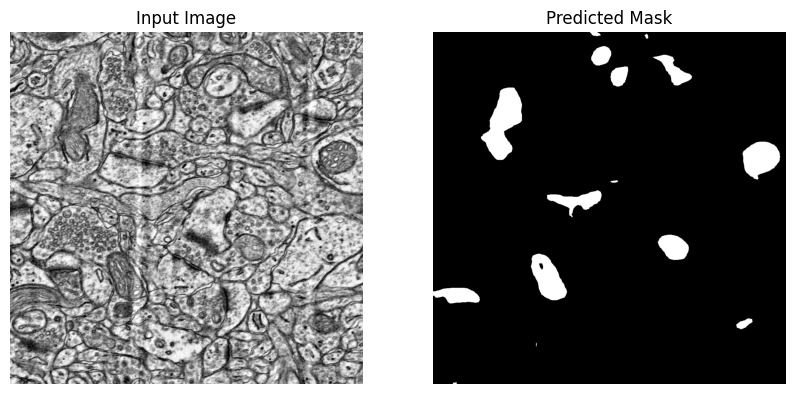

In [2]:
# test_inference.py
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.emcfsys.EMCellFiner.inference import infer_numpy, prepare_image
from emcfsys.EMCellFiner.models.UNet import UNet
from PIL import Image
def test_inference_single_image():
    # -------------------------
    # 1. 准备模型
    # -------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_path = r"D:\napari_EMCF\EMCFsys\emcfsys\save\best_model_epoch18_IoU=0.8514.pth"
    # -------------------------
    # 2. 准备测试图像
    # -------------------------
    img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_zZAXMi5nsjCDBo8m.tif"
    img = Image.open(img_path).convert("RGB")
    img = np.array(img)


    # ------------------------
    # 3. 运行推理
    # -------------------------
    mask = infer_numpy(model_path, img, device=device, threshold=0.5)
    print(mask.shape)
 
    # -------------------------
    # 4. 可视化
    # -------------------------
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

if __name__ == "__main__":
    test_inference_single_image()


In [4]:
mask

NameError: name 'mask' is not defined

In [ ]:
import torch
torch.load(r"D:\napari_EMCF\EMCFsys\emcfsys\save\best_model_epoch_1.pth")

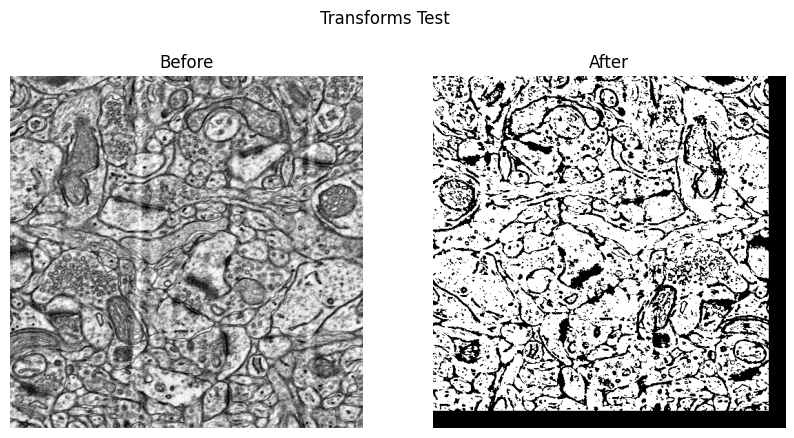

1
[0 1]


In [1]:
from src.emcfsys.EMCellFiner.transforms import (
    Compose, LoadImage, LoadMask, PhotometricDistortion, AlbumentationsTransform,
    RandomErasing, RandomScale, Pad, ToTensor,  RandomCrop, Resize, Normalize, RandomFlip
)
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
import numpy as np
def visualize(before_img, after_img, title=""):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(before_img)
    plt.title("Before")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(after_img)
    plt.title("After")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()

def main():

    # -------------------------
    # 输入路径，请自行修改
    # -------------------------
    img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_zZAXMi5nsjCDBo8m.tif"
    mask_path = r"D:\napari_EMCF\EMCFsys\emcfsys\label\Bock2011_2951_zZAXMi5nsjCDBo8m.png"

    # 用 OpenCV 加载，方便可视化
    before_img = Image.open(img_path).convert("RGB")
    before_img = np.array(before_img)

    # 反归一化，用于可视化
    mean = np.array([123,123.,123.])
    std  = np.array([58.,58.,58.])

    # -------------------------
    # 构建增强 pipeline
    # -------------------------
    pipeline = Compose([
        LoadImage(),                              # 读取图像
        LoadMask(),                               # 读取 mask
        Resize((512, 512)),                       # 固定缩放
        PhotometricDistortion(),                  # 颜色扰动（mmseg）
        AlbumentationsTransform(A.HorizontalFlip(p=.5)),  # Albumentations
        RandomScale((0.8, 1.4)),                  # 随机缩放
        RandomCrop((512, 512)), 
        Pad((512, 512)),                          # pad 到指定 size
        RandomErasing(prob=0.5),                  # cutout
        Normalize(mean=mean, std=std),# normalize
        ToTensor(),                               # 转为 tensor 风格 (C,H,W)
    ])

    # -------------------------
    # 执行增强
    # -------------------------
    results = {"img_path": img_path, "mask_path": mask_path}
    processed = pipeline(results)



    after_img = processed["img"].cpu().numpy().transpose(1,2,0)  # C,H,W -> H,W,C
    mask = processed["mask"].cpu().numpy()
    # print(after_img)
    after_img = ((after_img*255 * std + mean)).clip(0,255).astype(np.uint8)
    # print(after_img)
    visualize(before_img, after_img, title="Transforms Test")
    print(mask.max())
    print(np.unique(mask))
main()

In [6]:
mask_path = r"D:\napari_EMCF\EMCFsys\emcfsys\label\Bock2011_2951_zZAXMi5nsjCDBo8m.png"
from PIL import Image
import numpy as np
# Image.open(mask_path).convert("P")
mask = np.array(Image.open(mask_path).convert("P").resize((2222,512), Image.NEAREST))

In [7]:
mask.max()

np.uint8(1)

In [3]:
# Test SR model

In [1]:
import numpy as np 
from PIL import Image
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img, img2tensor
import torch
import src.emcfsys.EMCellFiner.hat.archs.hat_arch as HAT
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
# model = HAT.HAT()

# model.load_state_dict(torch.load(r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth")['params'])
path = r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth"
model = HATModel(path)
device = torch.device("cuda")
img = Image.open(r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif").convert("RGB").crop([0,0,128,512])

# 512, 512, 3 - > 3, 512, 512
img1 = np.array(img)

img_torch = torch.from_numpy(np.array(img1).astype(np.float32))/255.
img_torch = img_torch.permute(2,0,1)
img_torch = img_torch.unsqueeze(0).to(device)

model.to(device)
print(img_torch.shape)

output = model(img_torch)
print(output.shape)
# 3, 2048,2048 - > 2048,2048,3
output = output.cpu()
print(output.shape)
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img, img2tensor
img_out = tensor2img(output)
img = Image.fromarray(img_out)

c:\Users\YZY\miniconda3\envs\EMCF_napari\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
d:\napari_EMCF\EMCFsys\emcfsys\src\emcfsys\EMCellFiner\hat\models\hat_model.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no 

torch.Size([1, 3, 512, 128])
	Tile 1/1
torch.Size([1, 3, 2048, 512])
torch.Size([1, 3, 2048, 512])


In [8]:
import numpy as np 
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 假设你的项目路径配置正确
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img

# 1. 初始化模型
path = r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth"
# 显式指定 tile_size，防止显存溢出；对于小图可以不用 tile
model = HATModel(path) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. 读取与预处理
img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
# [修正1] crop 使用元组 (left, top, right, bottom)
# 这里的坐标代表: x从0到128(宽), y从0到512(高)
img = Image.open(img_path).convert("RGB")#.crop((0, 0, 512, 512))

# 转换为 Numpy 并归一化
img_np = np.array(img).astype(np.float32) / 255.

# 转换为 Tensor: (H, W, C) -> (C, H, W) -> (1, C, H, W)
img_torch = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(device)

print(f"Input Shape: {img_torch.shape}")

# 3. 推理
# 之前定义的 HATModel.forward 默认 use_tile=True
# 对于 128x512 这种小图，其实可以直接 use_tile=False 速度更快
with torch.no_grad():
    output = model(img_torch) 

print(f"Output Shape: {output.shape}")

# 4. 后处理
output = output.cpu()

# [修正2] 关键！设置 rgb2bgr=False
# 因为 Image.fromarray 需要 RGB 格式，而 tensor2img 默认转为 BGR (给OpenCV用的)
img_out = tensor2img(output, rgb2bgr=False, min_max=(0, 1))

# 5. 转回 PIL 图片
img_final = Image.fromarray(img_out)

# 验证结果
# img_final.show() 
# img_final.save("result_sr.png")
print("Done.")

d:\napari_EMCF\EMCFsys\emcfsys\src\emcfsys\EMCellFiner\hat\models\hat_model.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net_g.load_state_dict(torch.load(self.m

Input Shape: torch.Size([1, 3, 1024, 1024])
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Output Shape: torch.Size([1, 3, 4096, 4096])
Done.


In [1]:
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img
local_path = r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth"
# 1. 初始化模型
model = HATModel() 


c:\Users\YZY\miniconda3\envs\EMCF_napari\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Dwonloading model from : https://github.com/yzy0102/emcfsys/releases/latest/download/EMCellFiner.pth


In [2]:
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img
local_path = r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth"
# 1. 初始化模型
model = HATModel(local_path=local_path) 

Loading local model: D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth
Local model loaded successfully.


d:\napari_EMCF\EMCFsys\emcfsys\src\emcfsys\EMCellFiner\hat\models\hat_model.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(local_path, map_loca